# Notebook to reproduce _Figure 2_

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import FormatStrFormatter
import json

sys.path.append(os.path.join(sys.path[0], '../'))
from plot import plot_settings, plot_utils
from config import GEMINI_DIR

In [2]:
fig_dir = 'figure/fig2/' # move my figures here
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

# Load results

In [3]:
def get_performance(method):
    resfile = GEMINI_DIR + 'results/BioGrid/{}/results_by_subontology.txt'.format(method.upper())
    with open(resfile, 'r') as f:
        return json.load(f)

In [4]:
result_df = {'method': [], 'species': [], 'subontology': []}
for met in ['max f1', 'micro AUPRC', 'macro AUPRC']:
    result_df['mean {}'.format(met)] = []
    result_df['std dev {}'.format(met)] = []

for method in ['gemini', 'mashup', 'bionic', 'average_mashup', 'pca', 'svd']:
    full_perfs = get_performance(method)
    for org in ['yeast', 'mouse', 'human']:
        if method == 'bionic' and org != 'yeast':
            continue
        for ont in full_perfs[org]:
            result_df['method'].append(method)
            result_df['species'].append(org)
            result_df['subontology'].append(ont)
            for met_full, met_abbr in zip(['max f1', 'micro AUPRC', 'macro AUPRC'], ['f1', 'micro', 'macro']):
                result_df['mean {}'.format(met_full)].append(np.mean(full_perfs[org][ont][met_abbr]))
                result_df['std dev {}'.format(met_full)].append(np.std(full_perfs[org][ont][met_abbr]))

result_df = pd.DataFrame.from_dict(result_df)
result_df.head()

,method,species,subontology,mean max f1,std dev max f1,mean micro AUPRC,std dev micro AUPRC,mean macro AUPRC,std dev macro AUPRC
0,gemini,yeast,MF,0.573205,0.005625,0.599666,0.009557,0.183257,0.014727
1,gemini,yeast,BP,0.572142,0.009958,0.602541,0.011988,0.220043,0.011777
2,gemini,yeast,CC,0.728049,0.002715,0.796721,0.005248,0.420607,0.013640
3,gemini,mouse,MF,0.467093,0.004347,0.411245,0.005022,0.062232,0.003930
4,gemini,mouse,BP,0.357001,0.001390,0.298643,0.001741,0.046114,0.001874


# Now, let's make the figure from the result_df

In [5]:
subparts = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']
sp_ordering = [sp for sp in ['mouse', 'human', 'yeast'] for _ in range(3)]
met_ordering = [met for _ in range(3) for met in ['max f1', 'macro AUPRC', 'micro AUPRC']]
sp_ordering[:5], met_ordering[:5]

(['mouse', 'mouse', 'mouse', 'human', 'human'],
 ['max f1', 'macro AUPRC', 'micro AUPRC', 'max f1', 'macro AUPRC'])

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


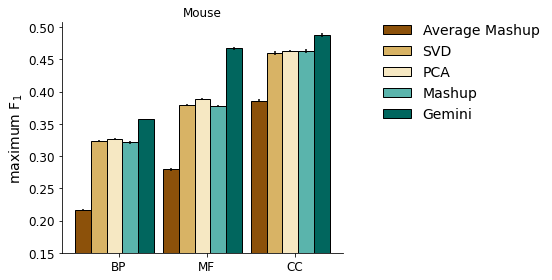

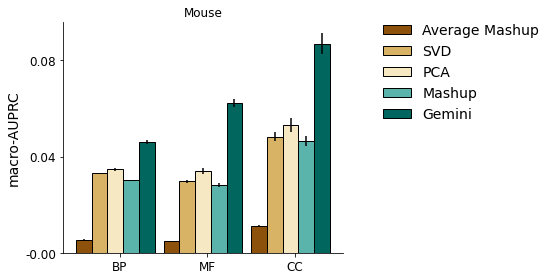

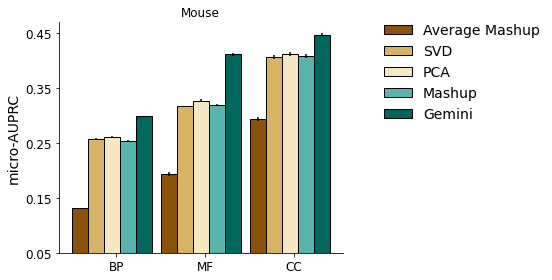

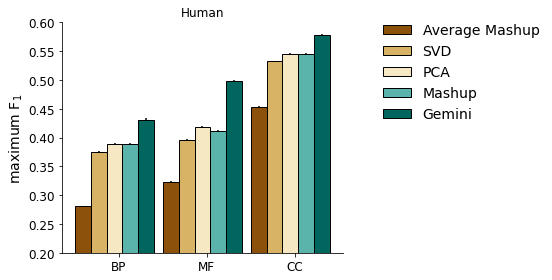

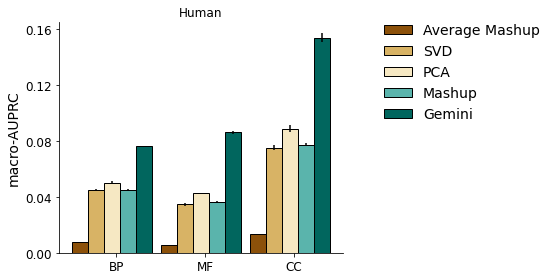

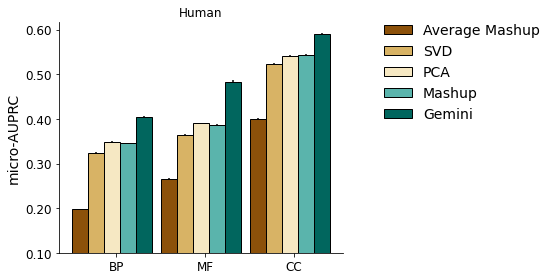

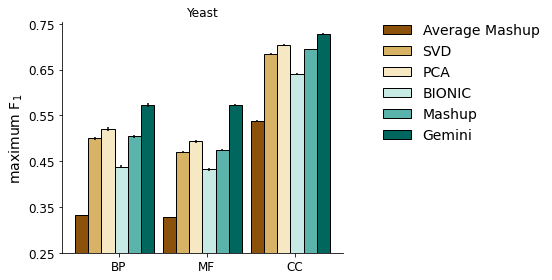

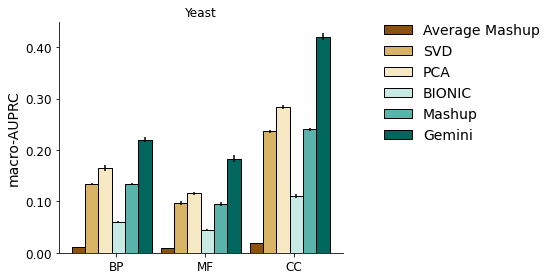

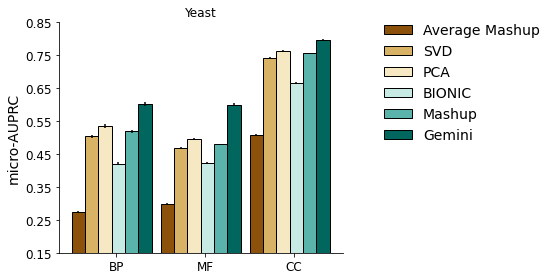

In [6]:
%matplotlib inline
for i in range(len(subparts)):
    org = sp_ordering[i]
    met = met_ordering[i]
    
    ax = plot_settings.get_wider_axis(True)
    models = plot_settings.MAIN_METHODS
    model_ordering = plot_settings.get_model_ordering(
        [m for m in models if m.lower() != 'bionic' or org == 'yeast'])
    
    means = []
    std_errs = []
    ont_ordering = ['BP', 'MF', 'CC']
    for subontology in ont_ordering:
        smeans, serrs = [], []
        dfOI = result_df[result_df['subontology'] == subontology]
        for mod in model_ordering:
            smeans.append(
                dfOI[(dfOI['method'] == mod.lower()) & (dfOI['species'] == org)]['mean {}'.format(met)].iloc[0])
            serrs.append(
                dfOI[(dfOI['method'] == mod.lower()) & (dfOI['species'] == org)]['std dev {}'.format(met)].iloc[0] / np.sqrt(5.))
        means.append(smeans)
        std_errs.append(serrs)

    min_val = plot_utils.out_min_val(means, 1/4)
    plot_utils.grouped_barplot(ax, means, ont_ordering, xlabel='', ylabel=plot_settings.get_metric_name(met),
                               color_legend=[plot_settings.get_model_name_conventions(m) for m in model_ordering],
                               nested_color=[plot_settings.get_model_colors(m) for m in model_ordering],
                               nested_errs=std_errs, tickloc_top=False, min_val=min_val, rotangle=0)
    ytickstep = 0.05 if met == 'max f1' and org != 'yeast' else 0.1 if met == 'max f1' and org == 'yeast' \
        else 0.1 if met == 'micro AUPRC' else 0.04 if org != 'yeast' else 0.1
    ymin, ymax = ax.get_ylim()
    ax.yaxis.set_ticks(np.arange(ymin, ymax+ytickstep/2., ytickstep))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
    plot_utils.format_legend(ax, *ax.get_legend_handles_labels())
    plot_utils.put_legend_outside_plot(ax)
    plot_utils.format_ax(ax)
    plt.title(org[0].upper() + org[1:].lower())
    plt.tight_layout()
    plt.savefig(fig_dir + 'figure2_{}.pdf'.format(subparts[i]))